In [1]:
import os, time, errno
import torch, tables
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import cv2

In [2]:
os.environ['CUDA_VISIBLE_DEVICES']='1'
savedir = '16x16-convnet'

In [3]:
T = 10 # time buckets

hdf5 = tables.open_file('captures/fei/R1_E3_AMES_200min_200f_14l_rgb.h5','r')
hdf5 = hdf5.root

try:
    dataset = np.load('captures/fei/cache.npy')
except FileNotFoundError:

    data = []
    for i in range(7):
        print('.',end='')
        batch = np.array(hdf5['data'][i*400:(i+1)*400])
        batch = batch.reshape(-1,T,int(batch.shape[1]/T),64,64,6).sum(2).astype(np.float32) # binning
        data.append(batch)
        
    dataset = np.concatenate(data,axis=0)
    dataset = np.moveaxis(dataset,[0,1,2,3,4],[0,1,3,4,2])
    np.save('captures/fei/cache.npy', dataset)
    
classes = np.array([np.array(itm.decode('utf-8').split('"'))[[1,3]].astype(np.int32)
                    for itm in np.array(hdf5['image_classes'].read())])

# Presented targets

In [4]:
imgs = hdf5["images"][0:100]
y,x = np.where(np.mean(imgs, axis=(0,3))>5)
xleft, xright, ytop, ybot = min(x), max(x), min(y), max(y)

images = hdf5["images"][:,ytop:ybot,xleft:xright]

tiny_images = []
for i in range(len(images)):
    tiny_images.append(cv2.resize(images[i],(64,64)))
images = np.stack(tiny_images)

# Model

In [5]:
class Block(torch.nn.Module):
    def __init__(self, filters):
        super(Block, self).__init__()
        
        self.block = torch.nn.Sequential(
            torch.nn.Conv2d(filters, filters, 3, padding=1, bias=False),
            torch.nn.BatchNorm2d(filters), torch.nn.ReLU(),
            torch.nn.Conv2d(filters, filters, 3, padding=1, bias=False),
            torch.nn.BatchNorm2d(filters))
        
    def forward(self, x):
        return F.relu(x + self.block(x))
    
class ConvNet(torch.nn.Module):
    def __init__(self, filters=128):
        super(ConvNet, self).__init__()
        self.filters = filters
        
        self.conv_in = torch.nn.Conv2d(10*6, filters, 9, padding=4, stride=2, bias=False)
        
        self.resnet = torch.nn.ModuleList()
        for i in range(101): self.resnet.append(Block(filters))
            
        self.conv_out =  torch.nn.ConvTranspose2d(self.filters, 1, 8, stride=8, bias=True)
        self.bias = torch.nn.Parameter(torch.Tensor(64,64))
        
        for name, parm in self.named_parameters():
            if name.endswith('weight'): torch.nn.init.normal_(parm, 0, .01)
            if name.endswith('bias'): torch.nn.init.constant_(parm, 0.0)
    
    def forward(self, x):
        x = x.view(-1,10*6,64,64)[:,:,::4,::4].contiguous()
        zx = F.relu(self.conv_in(x))
        for layer in self.resnet: zx = layer(zx)
        return torch.sigmoid(self.conv_out(zx).squeeze() + self.bias[None,:,:])

# Fit

In [6]:
data = torch.tensor(dataset)/30. # scaling
targets = torch.tensor(images).float().mean(3)/255.

In [7]:
train_data = data[[i for i in range(2800) if (i+1)%5 != 0]]
val_data = data[slice(4,2800,10)]
test_data = data[slice(9,2800,10)]

train_targets = targets[[i for i in range(2800) if (i+1)%5 != 0]]
val_targets = targets[slice(4,2800,10)]
test_targets = targets[slice(9,2800,10)]

In [8]:
batch_size = 50

model = ConvNet().cuda()
count = sum([np.prod(parm.shape) for parm in model.parameters() if parm.requires_grad])
print('Initialized a graph with {} parameters'.format(count))

train_history = []
val_history = []

model.eval()
loss = 0.
for i in np.random.permutation(len(val_data)//batch_size):
    start, end = i*batch_size, (i+1)*batch_size
    x,z = val_data[start:end].cuda(), val_targets[start:end].cuda()
    loss += ((model(x).detach() - z)**2).sum(1).mean()
val_history.append(loss/(len(val_data)//batch_size))
print('Initial Loss: {:2f}'.format(val_history[-1]))

Initialized a graph with 30472193 parameters
Initial Loss: 4.065594


In [9]:
batch_size = 50
optimizer = torch.optim.Adam(model.parameters(), lr=.0003)

try:
    print('epoch\ttrain loss\ttest loss\ttime\t\tutime')
    t0 = time.time()
    for epoch in range(500):
        model.train()
        loss_train = 0
        for i in np.random.permutation(len(train_data)//batch_size):
            start, end = i*batch_size, (i+1)*batch_size
            x,z = train_data[start:end].cuda(), train_targets[start:end].cuda()
            loss = ((model(x) - z)**2).sum(1).mean()
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            loss_train += loss.detach()
        train_history.append(loss_train/(len(train_data)//batch_size))

        if epoch % 1 == 0:
            t1 = time.time()
            model.eval()
            loss = 0.
            for i in range(len(val_data)//batch_size):
                start, end = i*batch_size, (i+1)*batch_size
                x,z = val_data[start:end].cuda(), val_targets[start:end].cuda()
                loss += ((model(x).detach() - z)**2).sum(1).mean()
            val_history.append(loss/(len(val_data)//batch_size))
            print('{:d}\t{:2f}\t{:2f}\t{:2f}\t{:2f}'.format(epoch,train_history[-1],val_history[-1],time.time()-t0, time.time()-t1))
            t0 = time.time()
            
except KeyboardInterrupt:
    print('Graceful Exit')
else:
    print('Finished')

epoch	train loss	test loss	time		utime
0	2.419028	3.807274	7.782624	0.185932
1	1.350108	2.179137	7.847406	0.185134
2	1.136528	1.332466	7.789790	0.185470
3	1.020541	1.504443	7.853281	0.186591
4	0.970827	1.147925	7.835845	0.184934
5	0.871889	1.068134	7.892514	0.187029
6	0.825070	1.262114	7.878825	0.186036
7	0.758628	1.321037	7.886041	0.186423
8	0.705748	1.077582	7.884253	0.186092
9	0.674943	1.084876	7.878946	0.186459
10	0.638145	0.997023	7.899894	0.186134
11	0.604092	1.160716	7.929423	0.186092
12	0.582622	1.197880	7.933501	0.189601
13	0.546026	1.025399	7.997918	0.190236
14	0.507560	1.044941	7.922894	0.188410
15	0.487196	1.044484	7.973913	0.188072
16	0.473780	1.055454	8.064742	0.187410
17	0.462934	0.964049	8.072068	0.187413
18	0.446162	0.909804	8.073491	0.188020
19	0.437059	1.006791	8.119334	0.187873
20	0.442094	0.970496	8.173457	0.187575
21	0.408072	0.935887	8.145116	0.187326
22	0.398866	1.108584	8.178270	0.187310
23	0.383142	1.038113	8.110428	0.185973
24	0.363367	0.861975	8.137968	0.186

207	0.058371	0.841356	8.373722	0.191221
208	0.058874	0.858406	8.358133	0.189505
209	0.058389	0.854354	8.336620	0.187706
210	0.058951	0.845908	8.333173	0.187861
211	0.060173	0.865443	8.357367	0.192604
212	0.059268	0.858087	8.325295	0.194305
213	0.058560	0.921714	8.328068	0.189323
214	0.057345	0.862879	8.359223	0.188000
215	0.055997	0.837262	8.310900	0.188303
216	0.056199	0.852498	8.330400	0.190301
217	0.058051	0.889535	8.353955	0.189358
218	0.063483	0.899565	8.387872	0.189810
219	0.060301	0.878188	8.384473	0.190031
220	0.065639	0.889269	8.407052	0.189618
221	0.077432	0.849413	8.400057	0.196748
222	0.077581	0.886768	8.362257	0.190818
223	0.069168	0.834225	8.356218	0.191513
224	0.067019	0.881893	8.325284	0.189753
225	0.059667	0.842095	8.329899	0.189724
226	0.054219	0.871134	8.345569	0.190076
227	0.050215	0.855809	8.390975	0.190394
228	0.047796	0.850786	8.338129	0.190290
229	0.045807	0.856663	8.369304	0.189947
230	0.044727	0.839652	8.365389	0.190108
231	0.043288	0.844637	8.326908	0.189906


412	0.026683	0.835023	8.350297	0.196257
413	0.028457	0.862636	8.374470	0.194615
414	0.029122	0.837204	8.365382	0.196035
415	0.029502	0.837501	8.386222	0.197513
416	0.029703	0.839163	8.414818	0.196002
417	0.029437	0.876899	8.387831	0.196211
418	0.029537	0.875517	8.392823	0.196359
419	0.029892	0.851862	8.377195	0.198861
420	0.028955	0.846848	8.380465	0.198097
421	0.027964	0.862420	8.368615	0.196407
422	0.025719	0.829425	8.366102	0.196118
423	0.024888	0.826263	8.374665	0.196178
424	0.024398	0.813596	8.405127	0.206293
425	0.023980	0.844567	8.372284	0.205051
426	0.023145	0.847410	8.357409	0.195974
427	0.022891	0.839430	8.348372	0.195382
428	0.022394	0.831147	8.373310	0.196490
429	0.022734	0.819354	8.346248	0.197820
430	0.023658	0.839916	8.361183	0.196447
431	0.024119	0.834762	8.379697	0.196286
432	0.024400	0.845154	8.380713	0.195929
433	0.026050	0.859982	8.389752	0.198379
434	0.027963	0.827053	8.324505	0.196092
435	0.030089	0.879997	8.367369	0.196715
436	0.033337	0.865305	8.353054	0.196243


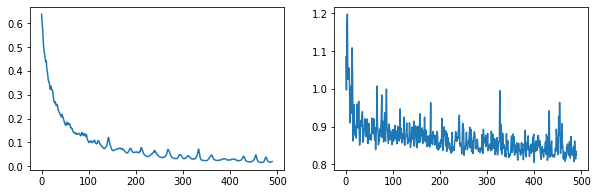

In [10]:
fig, ax = plt.subplots(1,2, figsize=(10,3))

ax[0].plot([itm.cpu().numpy() for itm in train_history[10:]])
ax[1].plot([itm.cpu().numpy() for itm in val_history[10:]])

In [11]:
model.eval()
loss = 0.
for i in np.random.permutation(len(test_data)//batch_size):
    start, end = i*batch_size, (i+1)*batch_size
    x,z = test_data[start:end].cuda(), test_targets[start:end].cuda()
    loss += ((model(x).detach() - z)**2).view(-1,64*64).sum(1).mean()
print('Final Loss: {:2f}'.format(loss/(len(test_data)//batch_size)))

Final Loss: 52.836048


In [14]:
try:
    os.makedirs(f'final-outputs/{savedir}')
except OSError as e:
    if e.errno != errno.EEXIST:
        raise

originals = False
try:
    os.makedirs('final-outputs/originals')
except OSError as e:
    if e.errno != errno.EEXIST:
        raise
    originals = True

train_idx = 0
val_idx = 0
test_idx = 0
for i in range(len(data)):
    person, pose = classes[i]
    if (i+1) % 5 != 0: # training data
        prefix = f'train{train_idx}'
        train_idx += 1
    elif (i+1) % 10 == 5: # validation data
        prefix = f'valid{val_idx}'
        val_idx += 1
    else: # (i+1) % 10 == 0 (test data)
        prefix = f'test{test_idx}'
        test_idx += 1
    
    recon = model(data[i].cuda()).detach().cpu().numpy()[0]
    cv2.imwrite(f'final-outputs/{savedir}/{prefix}-person{person}-pose{pose}.png', 255*recon)
    if not originals:
        cv2.imwrite(f'final-outputs/originals/{prefix}-person{person}-pose{pose}.png', 255*targets[i].numpy())

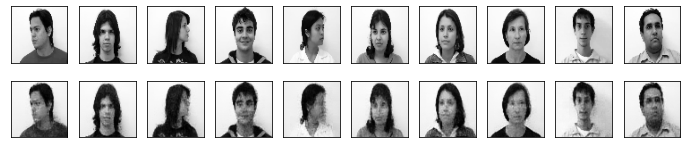

In [12]:
fig, ax = plt.subplots(2,10, figsize=(12,2.5))

model.eval()
reconstructions = model(train_data[0:10].cuda()).detach().cpu()
for i in range(10):
    ax[0,i].imshow(train_targets[i],cmap='Greys_r')
    ax[0,i].set_xticks([]); ax[0,i].set_yticks([])
    
    ax[1,i].imshow(reconstructions[i],cmap='Greys_r')
    ax[1,i].set_xticks([]); ax[1,i].set_yticks([])

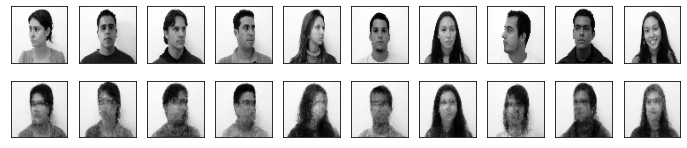

In [13]:
fig, ax = plt.subplots(2,10, figsize=(12,2.5))

model.eval()
reconstructions = model(test_data[0:10].cuda()).detach().cpu()
for i in range(10):    
    ax[0,i].imshow(test_targets[i],cmap='Greys_r')
    ax[0,i].set_xticks([]); ax[0,i].set_yticks([])
    
    ax[1,i].imshow(reconstructions[i],cmap='Greys_r')
    ax[1,i].set_xticks([]); ax[1,i].set_yticks([])